# Google Play Store Review: Sentiment Analysis & Prediction

### Assignment: 
- Transform sentiment carrying columns
- Predict sentiment with a supervised machine learning model

### About the dataset(s): 
- Source: https://www.kaggle.com/datasets/lava18/google-play-store-apps
- Description: This dataset consists of web scraped data of more than 10,000 Google Play Store apps and 60,000 app reviews. `data_reviews.csv` holds reviews of the apps, including the text of the review and sentiment scores.

### Data Dictionary:

**data_reviews.csv**

| variable               | class        | description                                           |
|:-----------------------|:-------------|:------------------------------------------------------|
| App                    | character    | The application name                                  |
| Translated_Review      | character    | User review (translated to English)                   |
| Sentiment              | character    | The sentiment of the user - Positive/Negative/Neutral |
| Sentiment_Polarity     | character    | The sentiment polarity score                          |
| Sentiment_Subjectivity | character    | The sentiment subjectivity score                      |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_colwidth=65

import nltk; nltk.download("punkt")
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud #!pip install wordcloud
from functools import reduce
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /Users/noel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Load the data and preview
- preview: data shape and first 10 rows of data
- heatmap: proportion of missing values

(64295, 5)


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, ca...",Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000
6,10 Best Foods for You,Amazing,Positive,0.60,0.900000
7,10 Best Foods for You,NaN,NaN,NaN,NaN
8,10 Best Foods for You,"Looking forward app,",Neutral,0.00,0.000000
9,10 Best Foods for You,It helpful site ! It help foods get !,Neutral,0.00,0.000000


Text(0.5, 1.0, 'Proportion of missing for each variable (%)')

<Figure size 720x360 with 0 Axes>

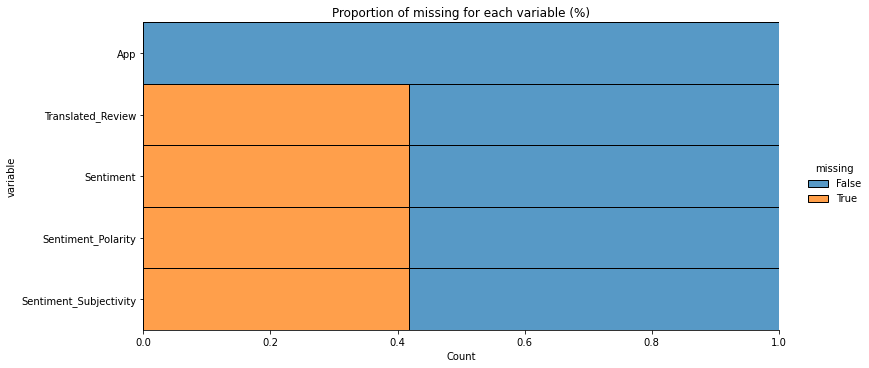

In [2]:
df = pd.read_csv('data_reviews.csv')
print(df.shape); display(df.head(10))

plt.figure(figsize=(10,5))
sns.displot(
    data=df.isna().melt(value_name="missing"), 
    y="variable", hue="missing", multiple="fill", aspect=2.25
); plt.title("Proportion of missing for each variable (%)")

# 2. Data pre-processing & cleaning
- lowercase all column names for ease of use
- drop rows to keep only Translated_Review is available
- drop rows to keep only +ve & -ve to build a binary classifer
- assign binary sentiment score according to sentiment labels, 0 = negative, 1 = positive
- drop columns to keep only [reviews and sentiment score]
- subset +ve & -ve respectively

In [3]:
df.columns=[i.lower() for i in df.columns]

df=df.dropna(subset='translated_review') # drop rows if Translated_Review==NA
df=df.drop(df[df['sentiment']=='neutral'].index) # drop rows if Sentiment==Neutrual
print(f"N={len(df)} after dropping rows of empty reviews and netural sentiment"); display(df.head())

df['sentiment_score']=[1 if i=='Positive' else 0 for i in df['sentiment']]
df=df[['translated_review', 'sentiment_score']].reset_index(drop=True)

df_pos = df[df['sentiment_score']==1]
df_neg = df[df['sentiment_score']==0]
print(f"N={len(df_pos)} for positive reviews"); display(df_pos.head())
print(f"N={len(df_neg)} for negative reviews"); display(df_neg.head())

N=37427 after dropping rows of empty reviews and netural sentiment


,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, ca...",Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


N=23998 for positive reviews


,translated_review,sentiment_score
0,"I like eat delicious food. That's I'm cooking food myself, ca...",1
1,This help eating healthy exercise regular basis,1
2,Works great especially going grocery store,1
3,Best idea us,1
4,Best way,1


N=13429 for negative reviews


,translated_review,sentiment_score
6,"Looking forward app,",0
7,It helpful site ! It help foods get !,0
19,God health,0
22,I found lot wealth form health...,0
26,On test....,0


# 3. Word cloud

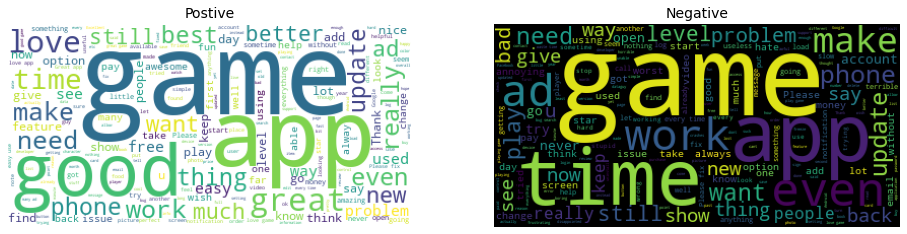

In [4]:
df_pos_words = reduce(lambda a,b: a+b, df_pos['translated_review'])
df_neg_words = reduce(lambda a,b: a+b, df_neg['translated_review'])

cloud_pos = WordCloud(background_color="white").generate(df_pos_words)
cloud_neg = WordCloud(background_color="black").generate(df_neg_words)

plt.figure(figsize=(16,10))

plt.subplot(121); plt.imshow(cloud_pos,cmap='gray'); plt.axis("off"); plt.title("Postive", size=14)
plt.subplot(122); plt.imshow(cloud_neg,cmap='gray'); plt.axis("off"); plt.title("Negative", size=14)
plt.show()

# 4. Text tokenization and vectorization
- texts to tokens: to create features 
- texts to numerical values using Tfidf Vectorizer: to train/fit prediction model

In [5]:
word_tokenized = [word_tokenize(review) for review in df["translated_review"]]
df["n_words"] = [len(word_tokenized[i]) for i in range(len(word_tokenized))] # new feature = the lengh of each review

vectorizer = TfidfVectorizer(
    stop_words=ENGLISH_STOP_WORDS,
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    max_features=200,  
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

vectorizer.fit(df['translated_review'])
vectorized=vectorizer.transform(df['translated_review'])

df_vectorized = pd.DataFrame(data=vectorized.toarray(), columns=vectorizer.get_feature_names_out())
df_vectorized

,able,access,account,actually,ad,add,ads,amazing,android,annoying,...,watch,way,wish,work,working,works,worst,wrong,year,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.617236,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.704145,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37422,0.0,0.0,0.0,0.0,0.0,0.0,0.71713,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.489258,0.0,0.0
37423,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
37424,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.383642,0.0,0.000000,0.0,0.000000,0.0,0.0
37425,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


# 5. Train a classifer and evaluate its performance
- drop columns of translated_review and n_words: using only sentiment_score as prediction endpoint (y)
- concate df (after dropping) and vectorized values: as predictors (X)
- split the dataset into training & testing sets
- use the y,X and training set to build a logistic-regression-based classifer
- apply the classifer to testing test to predict new sentiment
- performance evaluation using a confusion matrix (error calculation)

accuracy=0.8446433342238846
performance details:
neg sentiment correctly predicted: 0.2978893935345979
pos sentiment correctly predicted: 0.5467539406892866


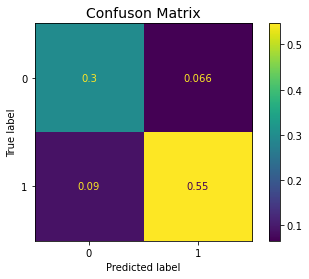

In [6]:
df_dropped = df.drop(["translated_review", "n_words"], axis=1)
df_transformed = pd.concat([df_dropped, df_vectorized], axis=1)

y = df_transformed["sentiment_score"]
X = df_transformed.drop("sentiment_score", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.2, 
    random_state=2023, 
)

classifer_log_reg = LogisticRegression().fit(X_train, y_train)
y_predicted = classifer_log_reg.predict(X_test)
print(f"accuracy={accuracy_score(y_test, y_predicted)}")

confusion_matrix_stats = confusion_matrix(y_test, y_predicted) / len(y_test)
print("performance details:")
print(f"neg sentiment correctly predicted: {confusion_matrix_stats[0][0]}")
print(f"pos sentiment correctly predicted: {confusion_matrix_stats[1][1]}")

ConfusionMatrixDisplay.from_estimator(classifer_log_reg, X_test, y_test, normalize="all")
plt.title("Confuson Matrix", size=14)
plt.show()